https://github.com/PacktPublishing/Hands-on-Reinforcement-Learning-with-PyTorch/blob/master/Section%204/4.3%20Policy%20Gradients%20REINFORCE%20Baseline.ipynb

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gym
import numpy as np

ModuleNotFoundError: No module named 'torch'

In [7]:
# check and use GPU if available if not use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
env = gym.make('LunarLander-v2')
env.reset()

for i in range(200):
    env.render()
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    if done:
        env.reset()


env.close()

In [9]:
class ActorNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(ActorNet, self).__init__()
        self.dense_layer_1 = nn.Linear(state_size, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, action_size)
    
    def forward(self, x):
        x = torch.clamp(x, min=-1.1, max=1.1) # clipping observation values
        x = F.relu(self.dense_layer_1(x))
        x = F.relu(self.dense_layer_2(x))
        return F.softmax(self.output(x), dim=-1) # -1 to take softmax of last dimension

class ValueFunctionNet(nn.Module):
    def __init__(self, state_size, hidden_size):
        super(ValueFunctionNet, self).__init__()
        self.dense_layer_1 = nn.Linear(state_size, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x = torch.clamp(x,-1.1,1.1)
        x = F.relu(self.dense_layer_1(x))
        x = F.relu(self.dense_layer_2(x))
        return self.output(x)

In [11]:
class PGAgent():
    def __init__(self, state_size, action_size, hidden_size, actor_lr, vf_lr, discount):
        self.action_size = action_size
        self.actor_net = ActorNet(state_size, action_size, hidden_size).to(device)
        self.vf_net = ValueFunctionNet(state_size, hidden_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor_net.parameters(), lr=actor_lr)
        self.vf_optimizer = optim.Adam(self.vf_net.parameters(), lr=vf_lr)
        self.discount = discount
    
    def select_action(self, state):
        # get action probs then randomly sample from the probabilities
        with torch.no_grad():
            input_state = torch.FloatTensor(state).to(device)
            action_probs = self.actor_net.forward(input_state)
            # detach and turn to numpy to use with np.random.choice()
            action_probs = action_probs.detach().cpu().numpy() # getting the action probability distribution
            action = np.random.choice(np.arange(self.action_size), p=action_probs) # use distribution to choose action
        return action
    
    def train(self, state_list, action_list, reward_list):
        # turn rewards into return
        trajectory_len = len(reward_list)
        return_array = np.zeros((trajectory_len, ))
        g_return = 0.

        # return_array = discounted [G_1,....,G_n]
        for i in range(trajectory_len-1, -1, -1):
            g_return = reward_list[i] + self.discount * g_return
            return_array[i] = g_return
        
        # create tensors
        state_t = torch.FloatTensor(state_list).to(device)
        action_t = torch.LongTensor(action_list).to(device).view(-1,1)
        return_t = torch.FloatTensor(return_array).to(device).view(-1,1)

        vf_t = self.vf_net.forward(state_t).to(device)
        with torch.no_grad():
            advantage_t = return_t - vf_t # G - b

        # calculate actor loss
        selected_action_prob = self.actor_net.forward(state_t).gather(1, action_t)
        # REINFORCE Baseline loss:
        actor_loss = torch.mean(-torch.log(selected_action_prob) * advantage_t)
        # backprob
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

         # calculate vf loss
        loss_fn = nn.MSELoss()
        vf_loss = loss_fn(vf_t, return_t) # loss = predicted return - actual return 
        # backprob
        self.vf_optimizer.zero_grad()
        vf_loss.backward()
        self.vf_optimizer.step()
        
        return actor_loss.detach().cpu().numpy(), vf_loss.detach().cpu().numpy()

In [16]:
env = gym.make('LunarLander-v2')
action_size = env.action_space.n
state_size = env.observation_space.shape[0]

# # set seed
# seed = 31
# env.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)

# hyperparameters
episodes = 5000 # run agent for this many episodes
hidden_size = 256 # number of units in NN hidden layers
actor_lr = 0.002 # learning rate for actor
value_function_lr = 0.002 # learning rate for value function
discount = 0.99 # discount factor gamma value
reward_scale = 0.01 #scale reward by this amount

agent = PGAgent(state_size, action_size, hidden_size, actor_lr, value_function_lr, discount)

In [17]:
stats_rewards_list = [] # store stats for plotting in this
stats_every = 10 # print stats every this many episodes
total_reward = 0
timesteps = 0
episode_length = 0
stats_actor_loss, stats_vf_loss = 0., 0.

for ep in range(episodes):
    state = env.reset()
    state_list, action_list, reward_list = [], [], []

    # stopping condition for training if agent reaches the amount of reward
    if len(stats_rewards_list) > stats_every and np.mean(stats_rewards_list[-stats_every:],axis=0)[1] > 190:
        print("Stopping at episode {} with average rewards of {} in last {} episodes".
            format(ep, np.mean(stats_rewards_list[-stats_every:],axis=0)[1], stats_every))
        break

    # train in each episode until episode is done
    while True:
        timesteps += 1
        # select an action from the agent's policy
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        episode_length += 1

        # store agent's trajectory
        state_list.append(state)
        action_list.append(action)
        reward_list.append(reward*reward_scale)

        # end episode early
        if total_reward < -250:
            done = 1
        
        # if episode is finished
        if done:
            # printing purpose
            actor_loss, vf_loss = agent.train(state_list, action_list, reward_list)
            stats_rewards_list.append((ep, total_reward, episode_length))
            stats_actor_loss += actor_loss
            stats_vf_loss += vf_loss

            # resetting
            total_reward = 0
            episode_length = 0

            # printing
            if ep % stats_every == 0:
                print('Episode: {}'.format(ep),
                    'Timestep: {}'.format(timesteps),
                    'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[1]),
                    'Episode length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]),
                    'Actor Loss: {:.4f}'.format(stats_actor_loss/stats_every), 
                    'VF Loss: {:.4f}'.format(stats_vf_loss/stats_every))
                stats_actor_loss, stats_vf_loss = 0., 0.

            break
        
        # transition into next state if episode is not done
        state = next_state


Episode: 0 Timestep: 106 Total reward: -261.5 Episode length: 106.0 Actor Loss: -0.2089 VF Loss: 0.2300
Episode: 10 Timestep: 1078 Total reward: -222.4 Episode length: 97.2 Actor Loss: -0.0898 VF Loss: 0.4212
Episode: 20 Timestep: 2001 Total reward: -247.9 Episode length: 92.3 Actor Loss: -0.2307 VF Loss: 0.2400
Episode: 30 Timestep: 2914 Total reward: -252.8 Episode length: 91.3 Actor Loss: 0.1040 VF Loss: 0.1939
Episode: 40 Timestep: 3889 Total reward: -236.6 Episode length: 97.5 Actor Loss: 0.0207 VF Loss: 0.2925
Episode: 50 Timestep: 5000 Total reward: -188.4 Episode length: 111.1 Actor Loss: 0.0564 VF Loss: 0.1742
Episode: 60 Timestep: 6136 Total reward: -177.4 Episode length: 113.6 Actor Loss: -0.2038 VF Loss: 0.4095
Episode: 70 Timestep: 7040 Total reward: -151.6 Episode length: 90.4 Actor Loss: 0.1639 VF Loss: 0.3245
Episode: 80 Timestep: 7942 Total reward: -140.0 Episode length: 90.2 Actor Loss: -0.0553 VF Loss: 0.1129
Episode: 90 Timestep: 8830 Total reward: -106.8 Episode le

Text(0, 0.5, 'Episode Reward')

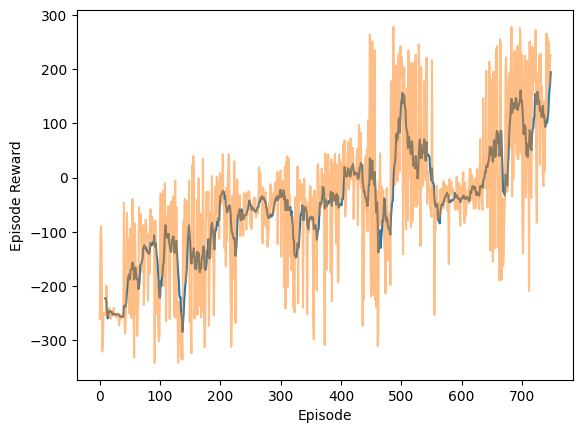

In [18]:
# plot stats
def get_running_stat(stat, stat_len):
    cum_sum = np.cumsum(np.insert(stat, 0, 0)) 
    return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len

episode, r, l = np.array(stats_rewards_list).T
cum_r = get_running_stat(r, 10)
cum_l = get_running_stat(l, 10)

# plot rewards
plt.plot(episode[-len(cum_r):], cum_r)
plt.plot(episode, r, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Reward')

Text(0, 0.5, 'Episode Length')

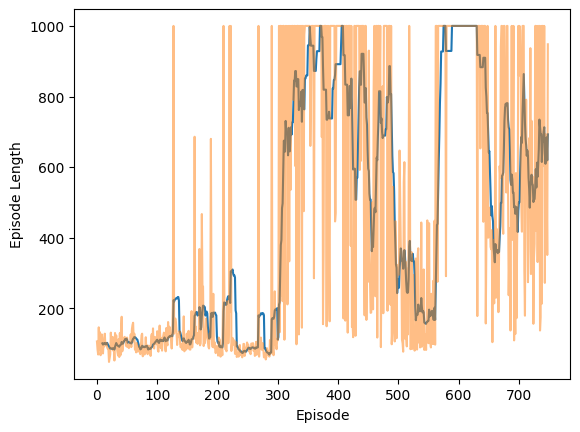

In [19]:
# plot episode lengths
plt.plot(episode[-len(cum_l):], cum_l)
plt.plot(episode, l, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Length')

In [21]:
# old agent play game
state = env.reset()
done = False

while not done:
    action = agent.select_action(state)
    state, reward, done, _ = env.step(action)
    env.render()

env.close()

In [22]:
# save old agent
PATH = 'D:/RL/policy-gradient/lunarlander_model'
torch.save(agent.actor_net.state_dict(), PATH)

In [29]:
# create new agent
PATH = 'D:/RL/policy-gradient/lunarlander_model'
new_agent = PGAgent(state_size, action_size, hidden_size, actor_lr, value_function_lr, discount)
new_agent.actor_net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [31]:
# new agent play game
state = env.reset()
done = False

while not done:
    action = new_agent.select_action(state)
    state, reward, done, _ = env.step(action)
    env.render()

env.close()